In [49]:
import os
import shap
import json
import time

import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import RepeatedKFold, LeaveOneOut, GridSearchCV
from sklearn import neighbors, metrics
from dotenv import load_dotenv

from models.linear_regressions import Linear_reg
from scripts.model_actions import freeze_model

load_dotenv()
sns.color_palette('colorblind')
plt.style.use('Solarize_Light2')

# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

pc_dpi = int(os.getenv('DPI'))

if pc_dpi is None:
    pc_dpi = 100


# <u>Tentative de modélisation et prédiction de la variable : Intensité d'émission de GàES</u>

## <u>1 : Modélisations en prenant en compte la note Energy Star (E*)</u>
### <u>1.1 : Régressions linéaires</u>

## <u>2 : Étude de l'importance de la note Energy Star</u>
### <u>2.1 : Feature importance via SHAP </u>
### <u>2.2 : Modélisation sans utiliser de variables E*</u>

## <u>3 : Application d'une méthode non-linéaire</u>

<hr>

## <u>1 : Modélisations prenant en compte toutes les variables retenues lors de l'étude</u>
### <u>1.1 : Régressions linéaires</u>

#### 1.1.a : Cross validation = Leave One Out
- On utilise dans un premier temps toutes les variables retenues lors de l'analyse exploratoire.
- Un split satisfaisant à déjà été trouvé et fixé, ces données viendront sur-écrire le split proposé par le modèle (ici la Classe) par défaut
- On effectue 4 régressions (OLS, Ridge, Lasso et Elastic Net) avec les paramètres par défaut de la classe pour la validation croisée : Leave One Out

In [50]:
general_file = "./data/seattle_std_scaled.csv"  # Used as backup


In [51]:
df_ghg = pd.read_csv(general_file)
df_ghg.set_index("OSEBuildingID", inplace=True)


In [52]:
df_ghg.head()


,scaled_Electricity(kWh),scaled_GHGEmissionsIntensity(kgCO2e/ft2),scaled_PropertyArea(SquareMetre)Total,scaled_SourceEUI(kWh/m2),scaled_NaturalGas(kWh),BuildingAge,NumberofBuildings,NumberofFloors,ENERGYSTARScore,Building_proportion,...,ohe_Nbhood_DOWNTOWN,ohe_Nbhood_EAST,ohe_Nbhood_GREATER DUWAMISH,ohe_Nbhood_LAKE UNION,ohe_Nbhood_MAGNOLIA / QUEEN ANNE,ohe_Nbhood_NORTH,ohe_Nbhood_NORTHEAST,ohe_Nbhood_NORTHWEST,ohe_Nbhood_SOUTHEAST,ohe_Nbhood_SOUTHWEST
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,
1,0.963847,1.770173,0.389139,1.012887,0.500705,95.0,1,12,60.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.615322,1.799564,0.659821,0.913481,4.178122,26.0,1,11,61.0,0.855,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.380423,3.572830,-0.095878,1.536320,1.009034,96.0,1,10,56.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.401384,1.074583,0.292078,0.455283,2.089235,96.0,1,11,27.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,-0.326328,3.945117,-0.029889,0.564008,2.706276,94.0,1,9,48.0,1.000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
df_ghg.columns


Index(['scaled_Electricity(kWh)', 'scaled_GHGEmissionsIntensity(kgCO2e/ft2)',
       'scaled_PropertyArea(SquareMetre)Total', 'scaled_SourceEUI(kWh/m2)',
       'scaled_NaturalGas(kWh)', 'BuildingAge', 'NumberofBuildings',
       'NumberofFloors', 'ENERGYSTARScore', 'Building_proportion',
       'Parking_proportion', 'EnergyStarCert', 'target_SourceEUI(kWh/m2)',
       'target_GHGEmissionsIntensity(kgCO2e/ft2)', 'ohe_Ptype_Hospital',
       'ohe_Ptype_Hotel', 'ohe_Ptype_K-12 School', 'ohe_Ptype_Large Office',
       'ohe_Ptype_Mixed Use Property', 'ohe_Ptype_Office', 'ohe_Ptype_Other',
       'ohe_Ptype_Refrigerated Warehouse', 'ohe_Ptype_Residence Hall',
       'ohe_Ptype_Small & Medium medical facility',
       'ohe_Ptype_Small & Mid-Sized Office',
       'ohe_Ptype_Supermarket & Grocery store', 'ohe_Ptype_Warehouse',
       'ohe_Ptype_Worship Facility', 'ohe_Nbhood_BALLARD',
       'ohe_Nbhood_CENTRAL', 'ohe_Nbhood_DELRIDGE', 'ohe_Nbhood_DOWNTOWN',
       'ohe_Nbhood_EAST', 'ohe_Nbh

In [54]:
# Target : target_GHGEmissionsIntensity(kgCO2e/ft2) :

droplist = [
    "scaled_GHGEmissionsIntensity(kgCO2e/ft2)",  # Scaled target
    "target_SourceEUI(kWh/m2)",  # not to scale
    "EnergyStarCert",
    ]

df_model = df_ghg.drop(columns=droplist)


In [55]:
ghg_target = "target_GHGEmissionsIntensity(kgCO2e/ft2)"
ghg_regression = Linear_reg(dataframe=df_model, target=ghg_target)


In [56]:
# Loading known split, ids are unique building OSE id

with open("./data/splits_ghg.json", "r") as json_file:
    splits = json.load(json_file)

ids_train = splits["train"]
ids_test = splits["test"]


In [57]:
# Overriding

df_train_override = df_model[df_model.index.isin(ids_train)]
df_test_override = df_model[df_model.index.isin(ids_test)]

ghg_regression.force_split(
    df_train_ovr=df_train_override,
    df_test_ovr=df_test_override
)


#### Exécution : 
Paramètres : 
- Ridge = 0.1, 45, step 0.05
- Elastic Net = Alpha = Alpha_ridge = 0.1, 45, step 0.05, default L1 ratio
- Lasso Alpha = 0.01, 15, 0.04

In [58]:
# Recheck default : 
ghg_regression.common_parameters["cv"] = None
#

alphas_ridge = np.arange(0.1, 45, 0.05)
alphas_elnet = alphas_ridge
alphas_lasso = np.arange(0.01, 15, 0.04)

ghg_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)



##### --> 1 Visualisation des alphas et leur pertinence, affichage des meilleurs hyperparamètre
##### --> 2 Comparaison des métriques

In [59]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.1
Time used during fit = 7.09582612500526
Time used during predict = 9.254098404198885e-05


Ridge: 

Ridge best Alpha : 6.350000000000001
Time used during fit = 0.1080133329378441
Time used during predict = 5.308294203132391e-05


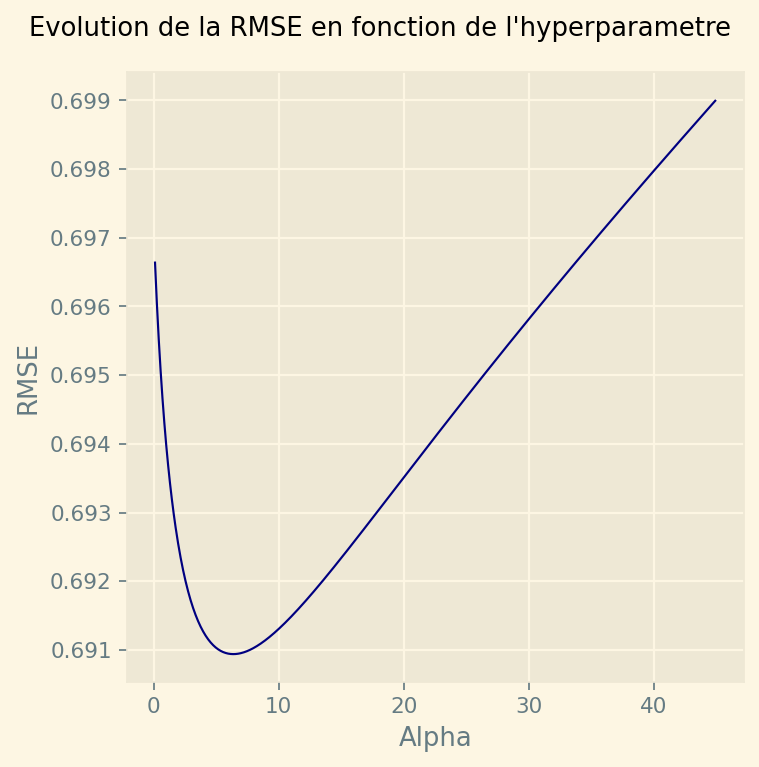

In [60]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")

ghg_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.19471941597294062
Time used during predict = 0.00014966691378504038


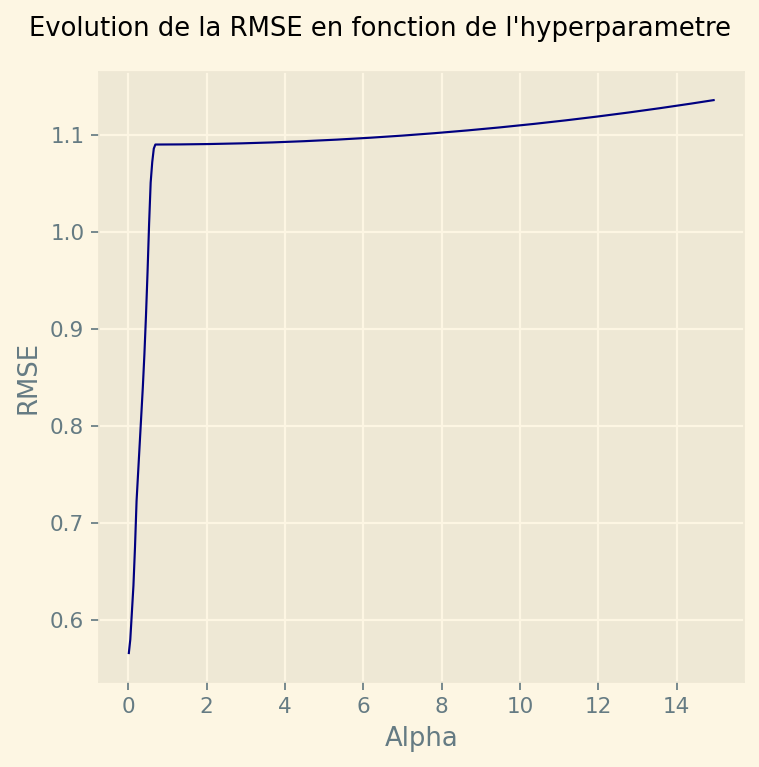

In [61]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")

ghg_regression.lasso_plot()


In [62]:
metrics_with_estar_l1out = ghg_regression.format_all_metrics()

df_predictions_estar_l1out = ghg_regression.df_predictions

metrics_with_estar_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.774188,0.305437,0.690939,0.612818,0.751307,0.594644,1.017116,0.580775
Test,0.690249,0.59779,0.689014,0.599228,0.703445,0.582265,0.714143,0.569463
Test/Train,0.892,1.957,0.997,0.978,0.936,0.979,0.702,0.981


In [63]:
# Saving Ridge Model and its predictions : 

ridge_l1out_estar = ghg_regression.ridge_cv
predictions_ridge_l1out_estar = ghg_regression.df_predictions["Ridge"]


##### Observation 1.1.a : 
- Ridge semble être le plus prometteur dans ce cas avec un score R2 supérieur à 0.6 et un rapport test/test stable.
- L'erreur est de .695 et .686 kg de CO2/m2 pour les données train/test, respectivement. Le plus bas de toutes les régressions
- On suit particulièrement la régression Ridge lors du passage a la vérification via Kfolds

In [64]:
# freeze_model(model=ghg_regression, save_file=True, file_path="./data/ghg_splits.json")
# uncomment to save train test split ids (OSEBuildingID)


#### 1.1.b : Cross validation = RepeatedKFold
- Mêmes paramètres que 1.1.a
- On effectue 4 régressions (OLS, Ridge, Lasso et Elastic Net), mise à jour des paramètres par défaut de la classe pour la validation croisée : RepeatedKfold(30 fois : 10 splits, 3 exécutions)
- On attend des temps de traitement nettement supérieurs

In [65]:
k_folds = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
ghg_regression.common_parameters["cv"] = k_folds


In [66]:
# Re executing all with adjusted cross validation parameters :

# alphas_ridge = np.arange(0.1, 45, 0.05)  <-- already assigned, commented as a reminder
# alphas_elnet = alphas_ridge
# alphas_lasso = np.arange(0.01, 15, 0.04)

ghg_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_ridge=alphas_ridge,
    alphas_lasso=alphas_lasso
)



In [67]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.1
Time used during fit = 44.33902262500487
Time used during predict = 0.00016904098447412252


In [68]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 7.850000000000002
Time used during fit = 22.090161875006743
Time used during predict = 7.54169886931777e-05


In [69]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.9782080829609185
Time used during predict = 0.0002234999556094408


In [70]:
metrics_with_estar_rkfold = ghg_regression.format_all_metrics()

df_predictions_estar_rkfold = ghg_regression.df_predictions

print("Kfold (10*3) : \n")

metrics_with_estar_rkfold


Kfold (10*3) : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.700331,0.479493,0.701814,0.61184,0.68769,0.594644,1.008899,0.580775
Test,0.690249,0.59779,0.689097,0.599132,0.703445,0.582265,0.714143,0.569463
Test/Train,0.986,1.247,0.982,0.979,1.023,0.979,0.708,0.981


In [71]:
print("Leave One Out : \n")

metrics_with_estar_l1out


Leave One Out : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.774188,0.305437,0.690939,0.612818,0.751307,0.594644,1.017116,0.580775
Test,0.690249,0.59779,0.689014,0.599228,0.703445,0.582265,0.714143,0.569463
Test/Train,0.892,1.957,0.997,0.978,0.936,0.979,0.702,0.981


##### Observations :
- Étonnamment, la validation croisée avec les paramètres utilisés (10 folds répétés 3 fois) n'offre pas de gain dans le cas de Ridge, au contraire.
- Les autres modèles de régression sont toujours moins performants, que ce soit au niveau de l'erreur ou du score R2, ainsi que la transition train/test
- Ridge Leave One Out se montre, dans ce cas, le meilleur candidat pour modéliser l'intensité d'émissions de GàES
- On utilise Ridge avec Leave One Out comme baseline.
- Le temps de traitement en utilisant la méthode Leave One Out est également beaucoup plus rapide que RKfolds

In [72]:
# Reverting to cv = None for l1out

ghg_regression.common_parameters["cv"] = None


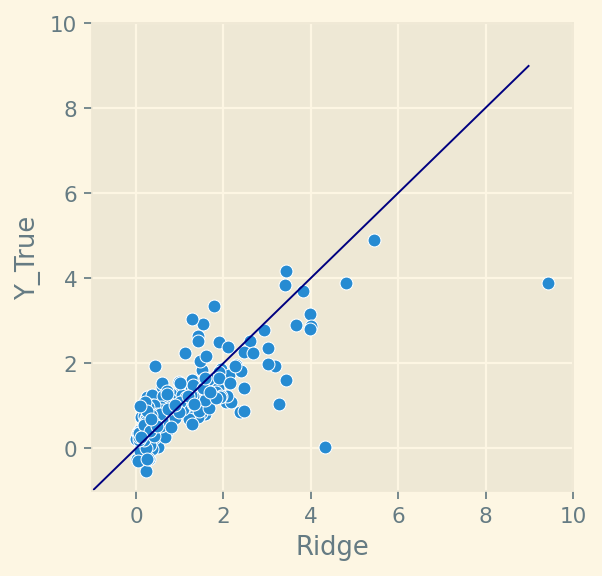

In [73]:
ghg_regression.use_ridge_cv(alphas=alphas_ridge)  # obj.df_predictions actualized and reset for shap

ghg_regression.scatter_true_pred(regression_name="Ridge")


#### Conclusion, partie 1 : 

- Ridge semble être le modèle à la fois le plus précis et le plus consistant. La validation via Kfolds n'offre pas d'avantages mais des pertes, que ce soit en terme de précision ou de temps.

## <u>2 : Etude de l'importance de la note Energy Star</u>

### <u>2.1 : Feature importance via SHAP</u>

In [74]:
X_all = ghg_regression.df_origin.drop(columns=[ghg_target]).to_numpy()
X100 = shap.utils.sample(X_all, 100) # 100 instances for use as the background distribution

features = ghg_regression.df_origin.drop(columns=[ghg_target]).columns

explainer = shap.LinearExplainer(ghg_regression.ridge_cv, X100, feature_names=features)
shap_values = explainer(X_all)


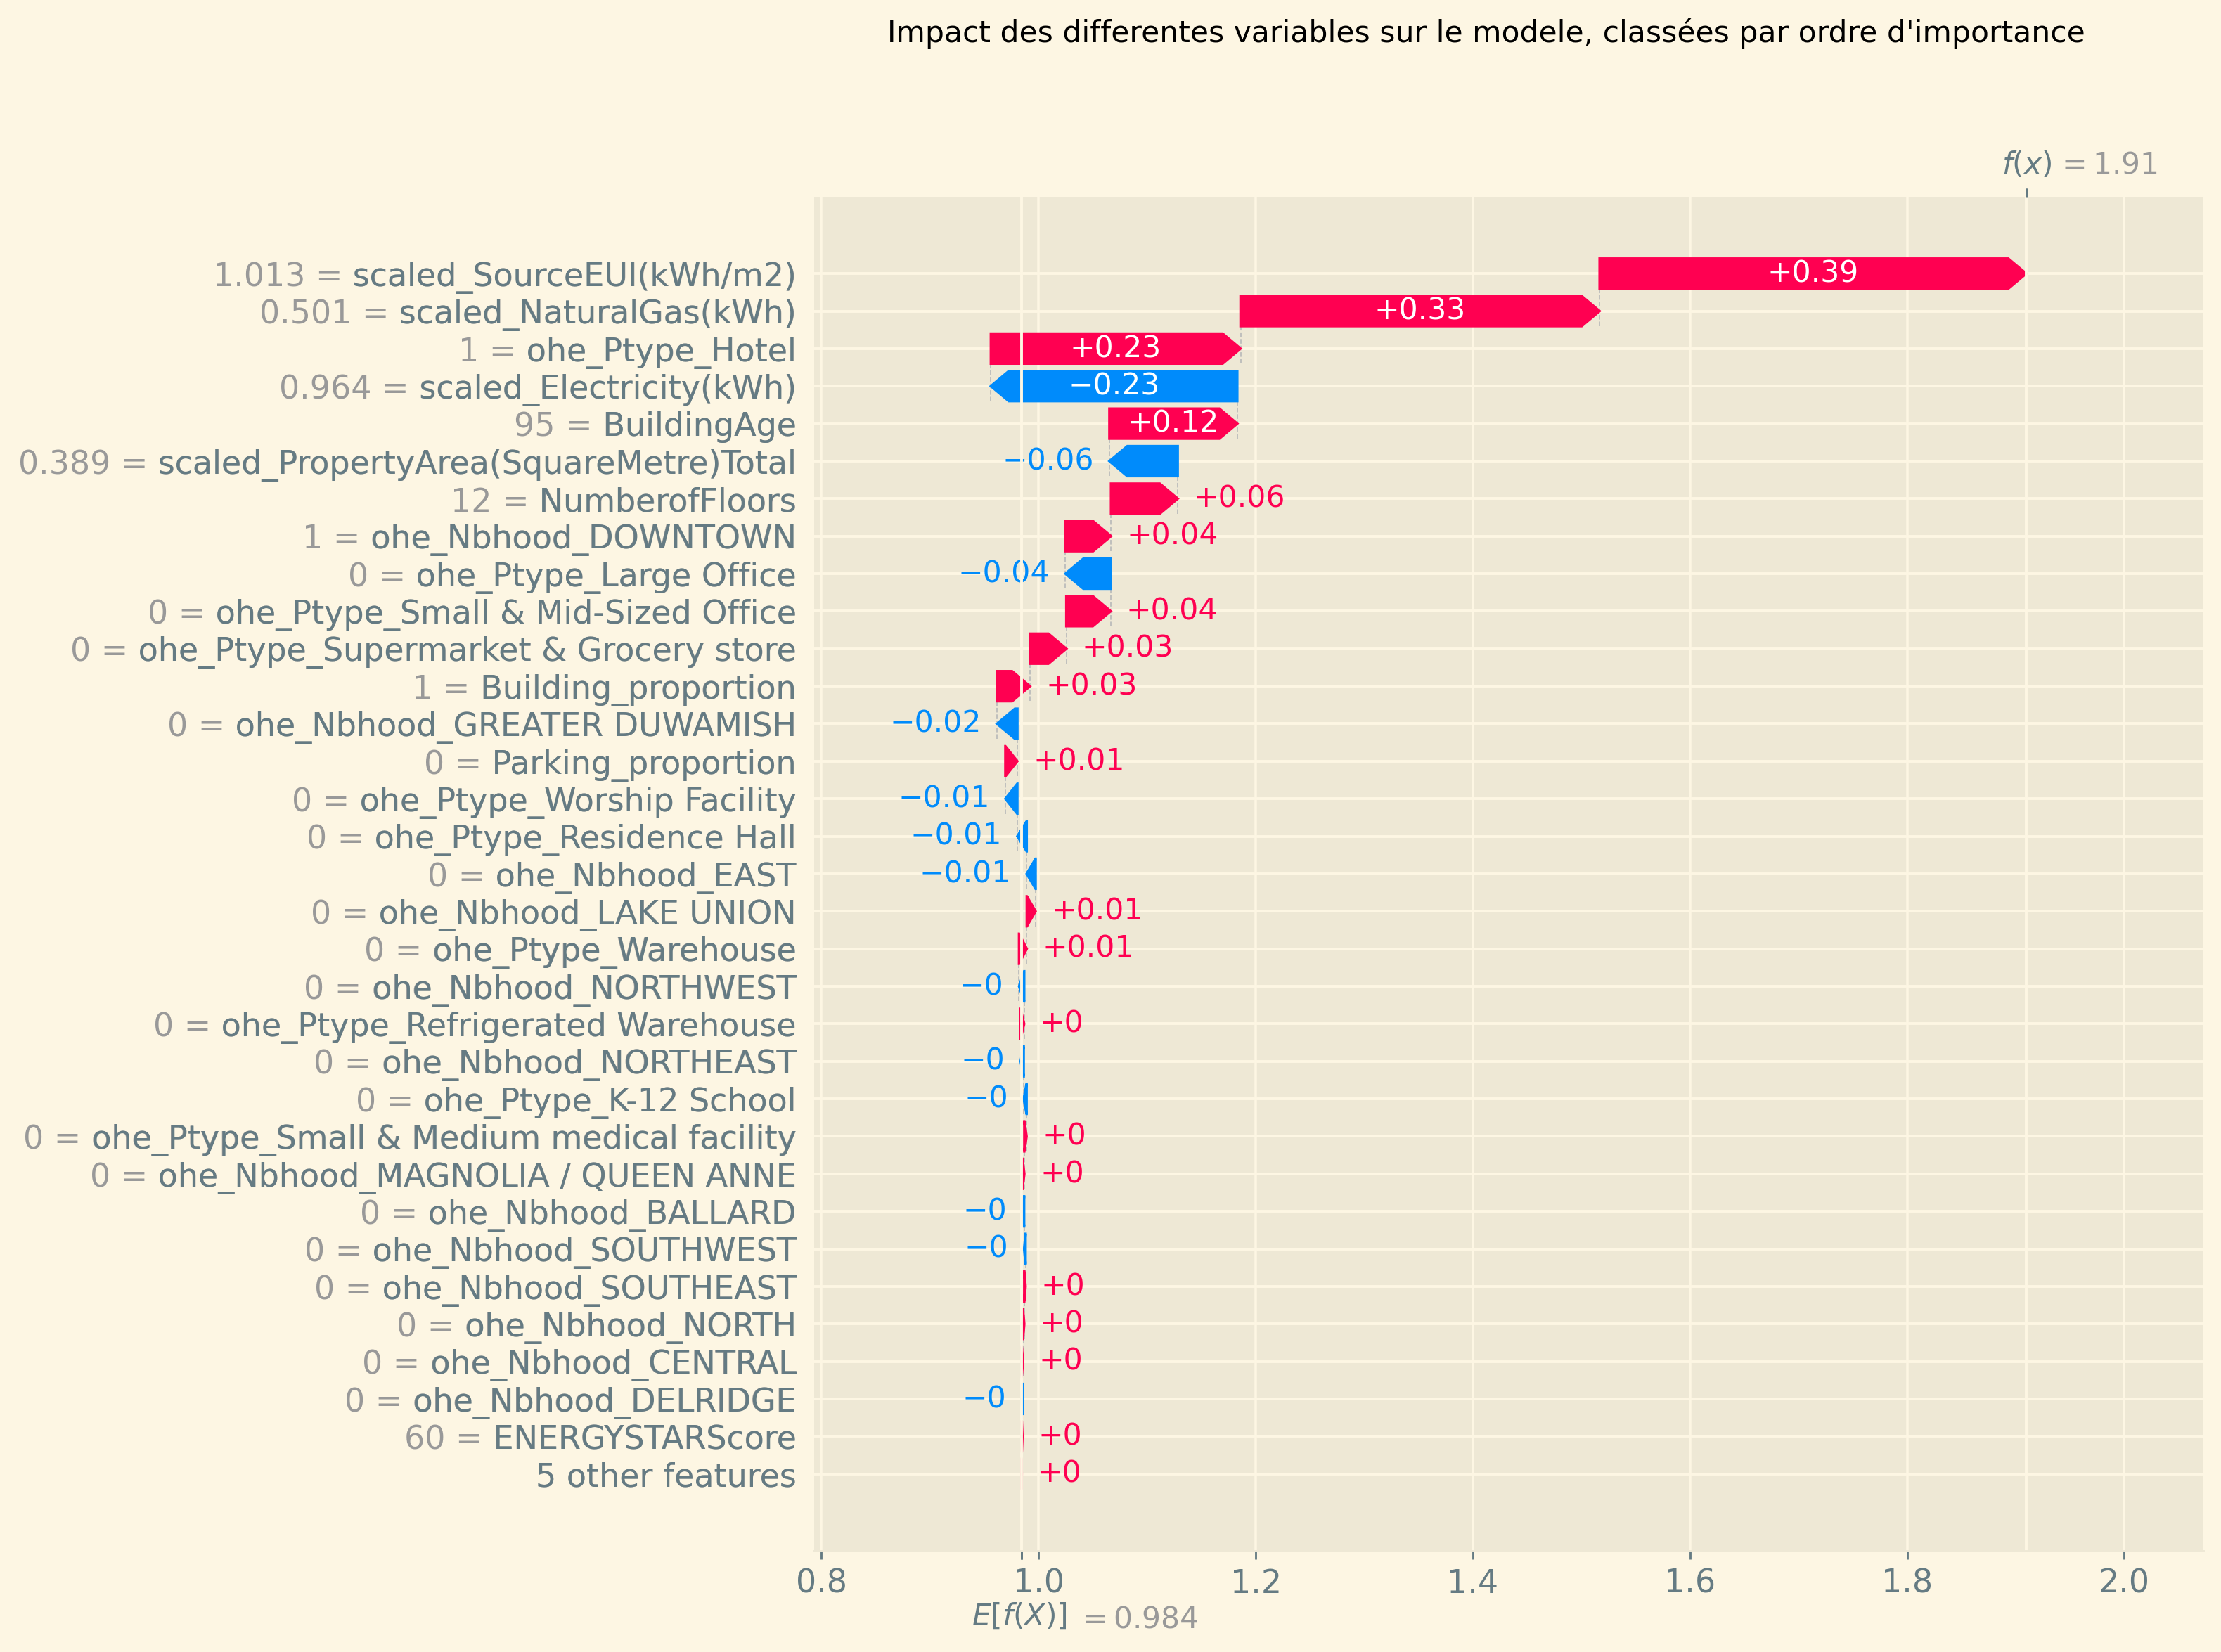

In [75]:
sample_ind = 18
my_waterfall = shap.plots.waterfall(shap_values[0], max_display=33, show=False)
my_waterfall.figure.set_size_inches(10, 10)
my_waterfall.figure.set_dpi(pc_dpi)

my_waterfall.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


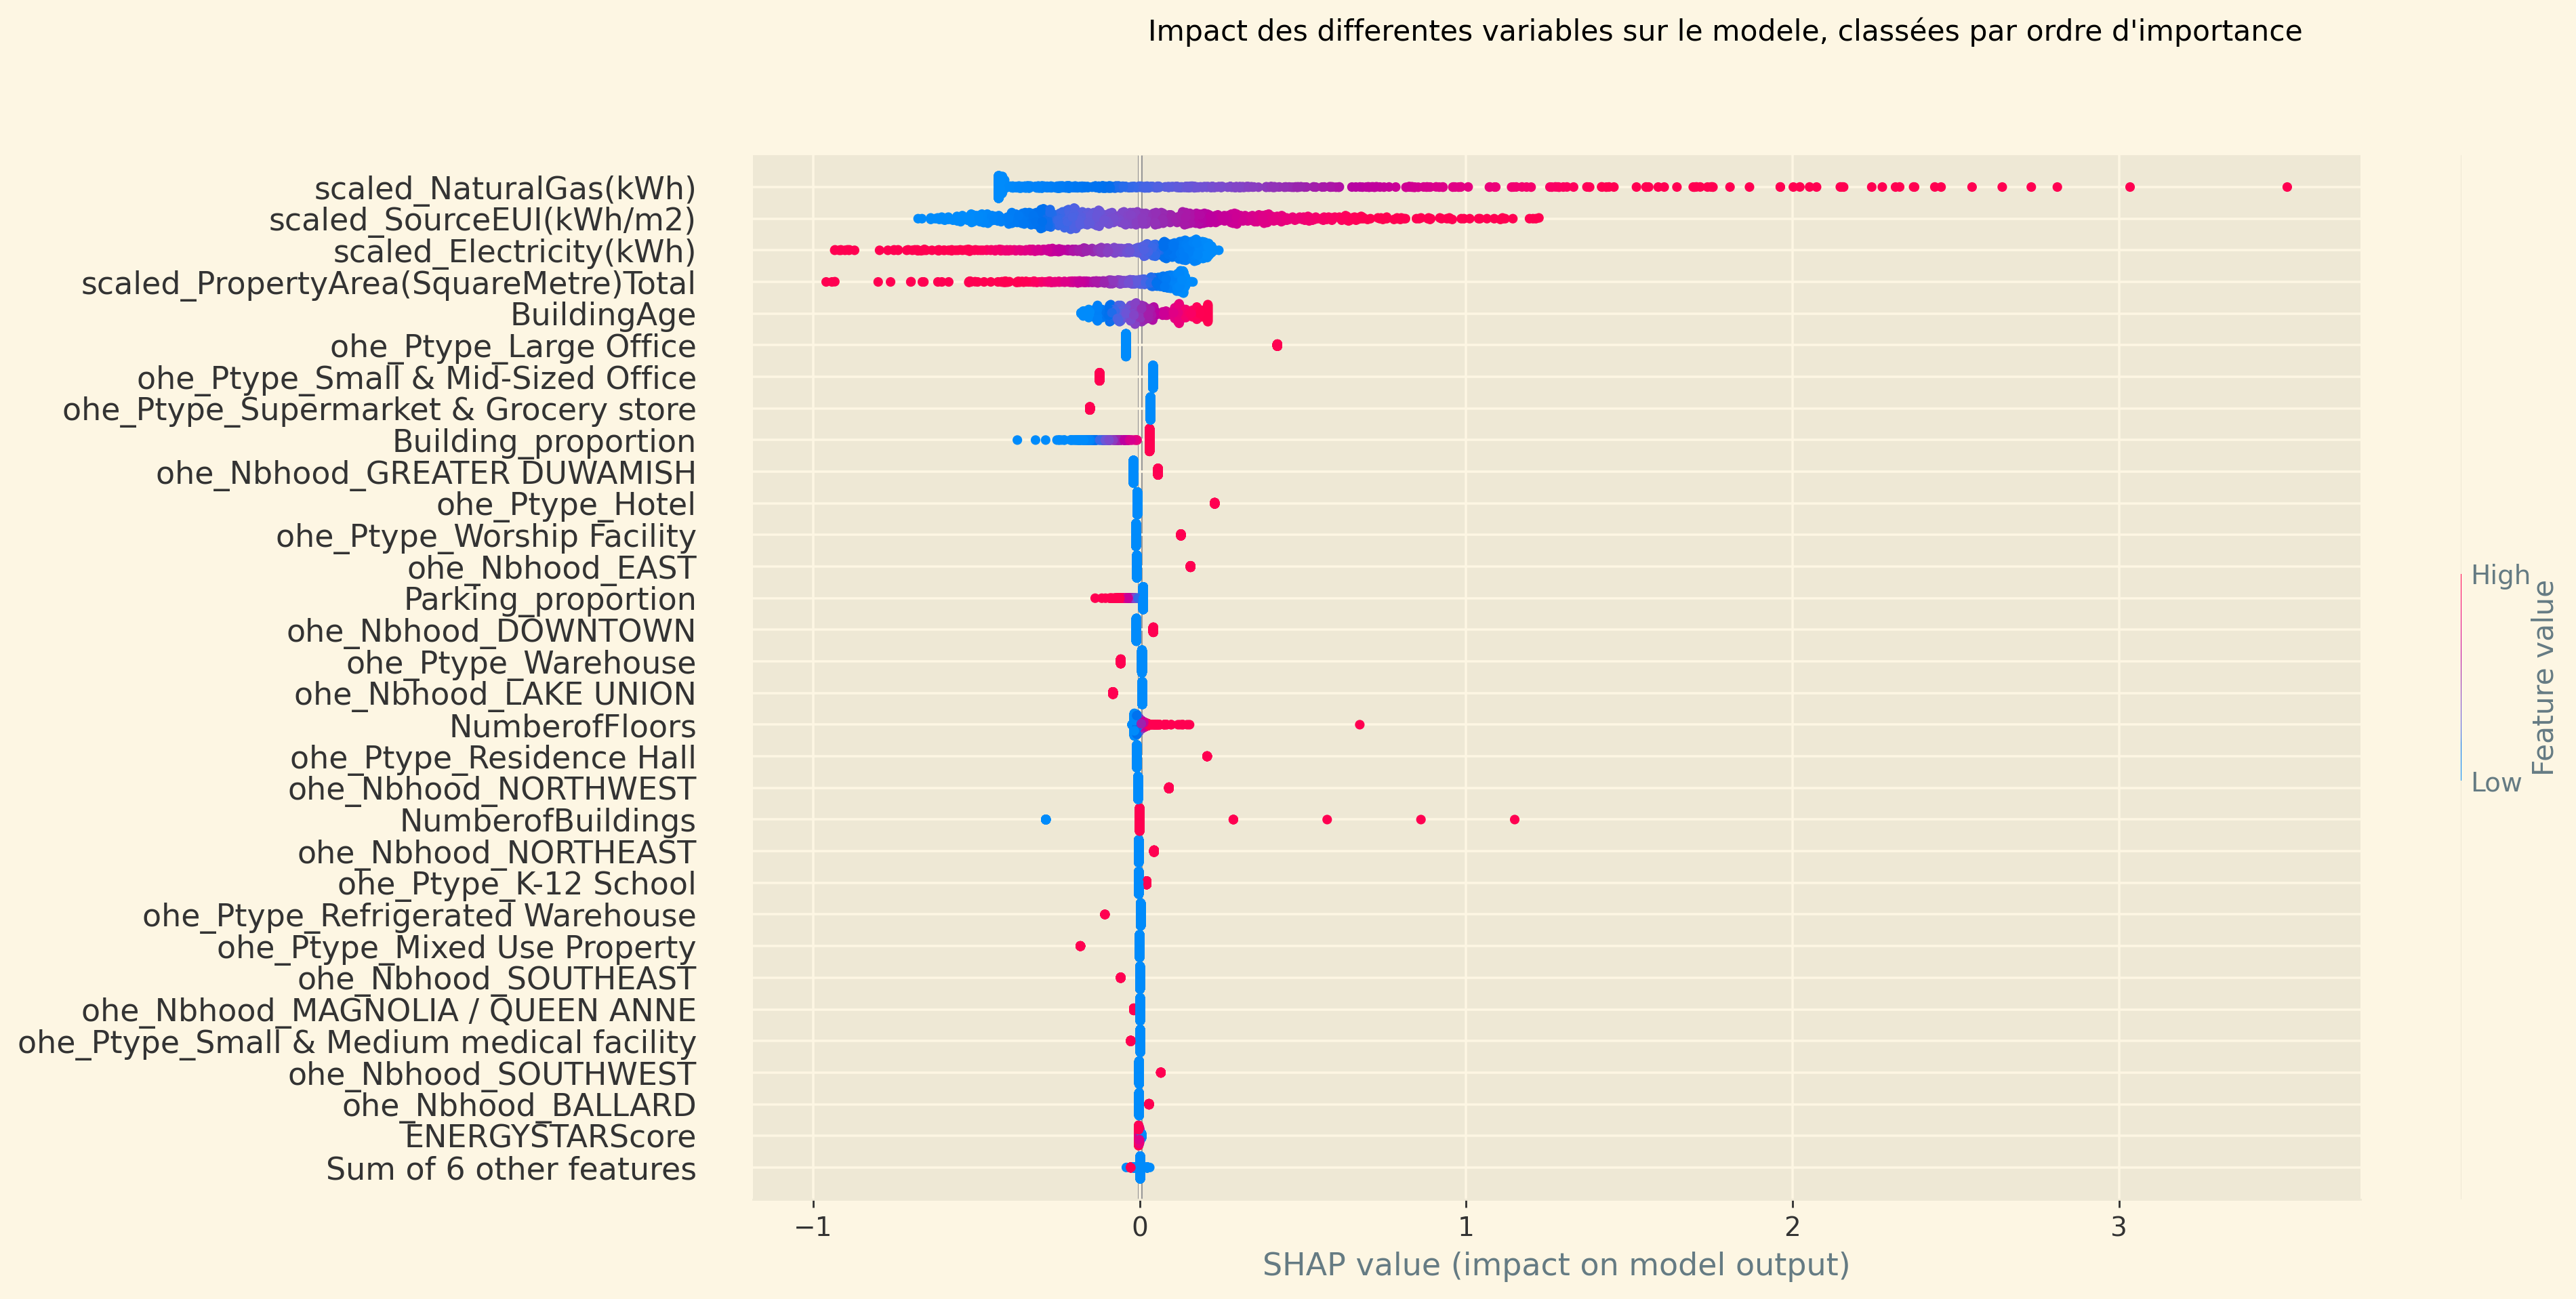

In [76]:
summary = shap.plots.beeswarm(shap_values, max_display=32, show=False)

summary.figure.set_size_inches(15, 8)
summary.figure.set_dpi(pc_dpi)

summary.suptitle("Impact des differentes variables sur le modele, classées par ordre d'importance")

plt.show()


#### Observations :

Dans le cas de la modélisation de l'intensité d'émission de GàES, l'impact du score ENERGYSTAR ne semble pas avoir d'importance. En effet, les graphes ci dessus montrent que la variable influe extrêmement peu sur la sortie du modèle : <b>Waterfall n1 : index = 33, < .01 || Summary n2 : index = 32, impact extrêmement faible</b> <br>
Ici, on peut émettre l'hypothèse que ne pas utiliser E* n'appauvrirait que très peu nos modèles <br>
Le modèle sélectionné à l'issue de la première partie de cette analyse était Ridge en utilisant un système de validation Leave One Out. <br>
On peut adapter la classe pour qu'elle abandonne le score E* et voir comment cela se traduit au niveau du modèle.

### <u>2.2 : Modélisation sans utiliser de variables E*</u>

In [77]:
drop_estar = ["ENERGYSTARScore"]
ghg_regression.drop_col(col_list=drop_estar)


In [78]:
# checking ENERGYSTARScore not in matrices : shape should be 1 less than original dfs

if ghg_regression.X_test.shape[1] >= len(ghg_regression.df_train.columns) + 1:  # +1 because target still in cols
    print("Oops")
else:
    print("Ok")


Ok


#### 2.2.a : Cross validation = Leave One Out
- Energy Star Score ne figure plus dans les matrices X_train, X_test
- Mêmes paramètres initiaux que la régression comportant E*

#### Exécution :
Paramètres : 
- Ridge = 0.1, 45, step 0.05
- Elastic Net = Alpha = Alpha_ridge = 0.1, 45, step 0.05, default L1 ratio
- Lasso Alpha = 0.01, 15, 0.04

In [79]:
ghg_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
    )


In [80]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.1
Time used during fit = 7.4197701250668615
Time used during predict = 0.0006774580106139183


Ridge: 

Ridge best Alpha : 6.750000000000002
Time used during fit = 0.07921020803041756
Time used during predict = 5.020794924348593e-05


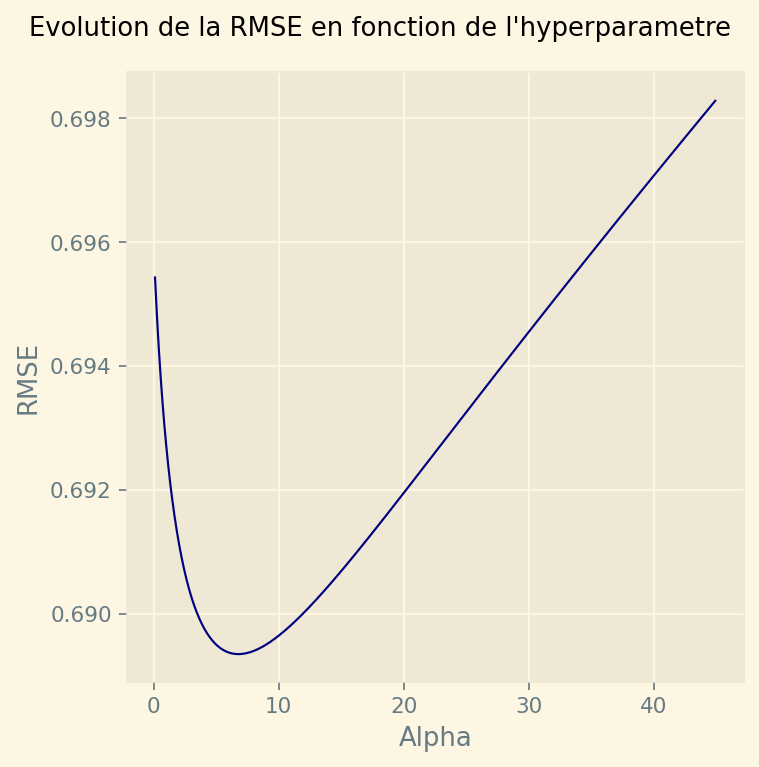

In [81]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")

ghg_regression.ridge_plot()


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.17104487493634224
Time used during predict = 0.00017424998804926872


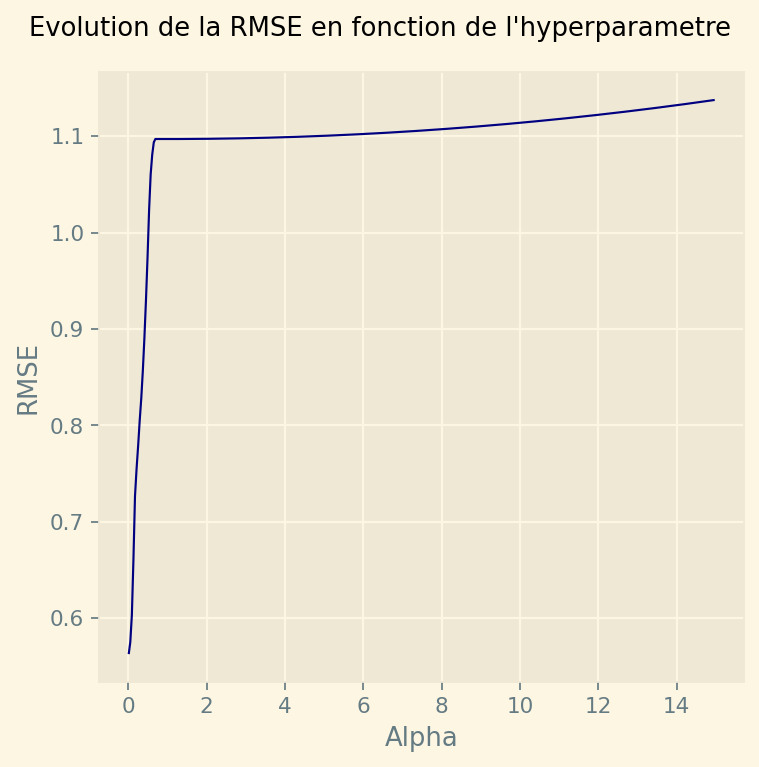

In [82]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")

ghg_regression.lasso_plot()


In [83]:
metrics_without_estar_l1out = ghg_regression.format_all_metrics()

df_predictions_no_estar_l1out = ghg_regression.df_predictions

metrics_without_estar_l1out


,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.772779,0.309007,0.689347,0.612533,0.750145,0.594596,1.021464,0.581245
Test,0.69112,0.596775,0.689267,0.598934,0.703411,0.582305,0.70937,0.575198
Test/Train,0.894,1.931,1.0,0.978,0.938,0.979,0.694,0.99


#### 2.2.b : Cross validation = RepeatedKfold
- Mêmes paramètres que 2.2.a
- On effectue 4 régressions (OLS, Ridge, Lasso et Elastic Net) mise à jour des paramètres par défaut de la classe pour la validation croisée : RepeatedKfold(30 fois : 10 splits, 3 exécutions)
- On attend des temps de traitement nettement supérieurs

In [84]:
ghg_regression.common_parameters["cv"] = k_folds


In [85]:
ghg_regression.execute_all(
    alphas_elnet=alphas_elnet,
    alphas_lasso=alphas_lasso,
    alphas_ridge=alphas_ridge
    )


In [86]:
print("Elnet : \n")
print(f"Elastic Net L1 Ratio : {ghg_regression.elnet_cv.l1_ratio_}")
print(f"Elastic Net best Alpha : {ghg_regression.elnet_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.elnet_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.elnet_time_card.t_predict}")


Elnet : 

Elastic Net L1 Ratio : 0.01
Elastic Net best Alpha : 0.1
Time used during fit = 44.160187166999094
Time used during predict = 0.001031791907735169


In [87]:
print("Ridge: \n")
print(f"Ridge best Alpha : {ghg_regression.ridge_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.ridge_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.ridge_time_card.t_predict}")


Ridge: 

Ridge best Alpha : 8.200000000000003
Time used during fit = 23.786760792019777
Time used during predict = 6.245891563594341e-05


In [88]:
print("LASSO: \n")
print(f"LASSO best Alpha : {ghg_regression.lasso_cv.alpha_}")
print(f"Time used during fit = {ghg_regression.lasso_time_card.t_fit}")
print(f"Time used during predict = {ghg_regression.lasso_time_card.t_predict}")


LASSO: 

LASSO best Alpha : 0.01
Time used during fit = 0.9477630419423804
Time used during predict = 0.00010583410039544106


In [89]:
print("Metrics using Leave One Out method, E* in model : \n")

metrics_with_estar_l1out


Metrics using Leave One Out method, E* in model : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.774188,0.305437,0.690939,0.612818,0.751307,0.594644,1.017116,0.580775
Test,0.690249,0.59779,0.689014,0.599228,0.703445,0.582265,0.714143,0.569463
Test/Train,0.892,1.957,0.997,0.978,0.936,0.979,0.702,0.981


In [90]:
metrics_without_estar_kfold = ghg_regression.format_all_metrics()

print("Metrics using repeated Kfold method (10, 3 repeats), E* not in model : \n")

metrics_without_estar_kfold


Metrics using repeated Kfold method (10, 3 repeats), E* not in model : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.69869,0.482473,0.704174,0.611613,0.68575,0.594596,1.012392,0.581245
Test,0.69112,0.596775,0.689098,0.599131,0.703411,0.582305,0.70937,0.575198
Test/Train,0.989,1.237,0.979,0.98,1.026,0.979,0.701,0.99


In [91]:
print("Metrics using Leave One Out method, E* in model : \n")

metrics_with_estar_l1out


Metrics using Leave One Out method, E* in model : 



,RMSE_OLS,R2_OLS,RMSE_Ridge,R2_Ridge,RMSE_LASSO,R2_LASSO,RMSE_Elastic_Net,R2_Elastic_Net
Train,0.774188,0.305437,0.690939,0.612818,0.751307,0.594644,1.017116,0.580775
Test,0.690249,0.59779,0.689014,0.599228,0.703445,0.582265,0.714143,0.569463
Test/Train,0.892,1.957,0.997,0.978,0.936,0.979,0.702,0.981


## <u>3 : Utilisation d'une méthode non linéaire : régression via KNN</u>

- Le problème semble être adapté à l'utilisation de méthodes de régressions linéaires
- On peut vérifier cela en utilisant une méthode de modélisation non linéaire (ici régression par KNN) et comparer les performances des deux modèles (comparaison avec le meilleur modèle linéaire : Ridge).
- On utilise exactement les mêmes données (provenant de la Classe Linear_reg), en gardant le même split.
- On effectue deux validations croisées : Une fois en utilisant LeaveOneOut, et une autre fois en utilisant Kfolds (mêmes paramètres que pour les régressions linéaires)
- On utilise la même métrique (MSE) pour la recherche d'hyperparamètre. 

In [92]:
ghg_regression.reset_cols()  # We can reset the columns so that E* score is used

X_train, X_test = ghg_regression.X_train, ghg_regression.X_test
y_train, y_test = ghg_regression.y_train, ghg_regression.y_test

neighbors_candidates = [5, 7, 9, 11, 13, 15, 17, 19]

knnr = neighbors.KNeighborsRegressor()

# Grid search

l1out = LeaveOneOut()

param_grid_knnr = {'n_neighbors':neighbors_candidates}

score = "neg_mean_squared_error"

# KNN regressors Setup

knn_reg_l1o = GridSearchCV(
    estimator=knnr,
    param_grid=param_grid_knnr,
    cv=l1out,
    scoring=score
)

knn_reg_rkf = GridSearchCV(
    estimator=knnr,
    param_grid=param_grid_knnr,
    cv=k_folds,
    scoring=score
)


In [93]:
knnr_l1o_fit_ts = time.perf_counter()

knn_reg_l1o.fit(
    X=X_train,
    y=y_train
)

knnr_l1o_fit_tf = time.perf_counter()

time_to_fit_knn_l1out = knnr_l1o_fit_tf - knnr_l1o_fit_ts

rmse_knnr_l1o = np.sqrt(abs(knn_reg_l1o.best_score_))
y_pred_train_l1o = knn_reg_l1o.predict(X_train)
r2_knnr_l1o = metrics.r2_score(y_true=ghg_regression.y_train, y_pred=y_pred_train_l1o)


In [94]:
print(f"RMSE Regression KNN, Cross Val : Leave one out = {rmse_knnr_l1o}")
print(f"Score R2 Regression KNN, Cross Val : Leave one out = {r2_knnr_l1o}")
print(f"Temps fit : {time_to_fit_knn_l1out}")
print(f"Meilleur hyperparametre : {knn_reg_l1o.best_params_}")


RMSE Regression KNN, Cross Val : Leave one out = 0.9168994879457898
Score R2 Regression KNN, Cross Val : Leave one out = 0.2371457601143503
Temps fit : 4.389831374981441
Meilleur hyperparametre : {'n_neighbors': 17}


#### Observations, cas régression KNN, validation croisée Repeated Kfolds : 
- Le score R2 est beaucoup plus faible tous les autres scores obtenus lors de régressions linéaires
- L'erreur augmente également significativement
- Le temps de traitement pour fit (3.9s) est largement supérieur à celui de Ridge utilisant Leave One Out (0.071s)
- On effectue la même expérimentation en utilisant la validation croisée plus rigoureuse : KFolds répétés (3 * 10 folds) pour avoir une conclusion définitive sur le modèle de régression par KNN

In [95]:
knnr_rkf_fit_ts = time.perf_counter()

knn_reg_rkf.fit(
    X=X_train,
    y=y_train
)

knnr_rkf_fit_tf = time.perf_counter()

time_to_fit_knn_rkf = knnr_rkf_fit_tf - knnr_rkf_fit_ts

rmse_knnr_rkf = np.sqrt(abs(knn_reg_rkf.best_score_))
y_pred_train_rkf = knn_reg_rkf.predict(X_train)
r2_knnr_rkf = metrics.r2_score(y_true=ghg_regression.y_train, y_pred=y_pred_train_l1o)


In [96]:
print(f"RMSE Regression KNN, Cross Val : Repeated KFolds = {rmse_knnr_rkf}")
print(f"Score R2 Regression KNN, Cross Val : Repeated KFolds = {r2_knnr_rkf}")
print(f"Temps fit : {time_to_fit_knn_rkf}")
print(f"Meilleur hyperparametre : {knn_reg_rkf.best_params_}")


RMSE Regression KNN, Cross Val : Repeated KFolds = 0.920924292756616
Score R2 Regression KNN, Cross Val : Repeated KFolds = 0.2371457601143503
Temps fit : 0.4597469170112163
Meilleur hyperparametre : {'n_neighbors': 15}


## Conclusions :

- Sur les modèles testés, le problème semble être plus aisément solvable en utilisant des méthodes de régressions linéaires (scores faibles en utilisant régression via KNN par ex.)

L'hypothèse selon laquelle E* serait indispensable à la modélisation de prédictions <u>concernant les émissions de GàES</u> semble fausse. Le modèle Ridge est suffisamment robuste. L'analyse via SHAP et les comparaisons entre les différentes méthodes nous montrent que, vis à vis de nos données, l'utilisation d'une régression Ridge est optimale. La note E* apporte trop peu au modèle pour être considérée comme vitale. Les gains apportés ne valent pas les efforts demandés pour l'obtenir.

- Recommandations issues de l'étude : Ridge utilisant comme hyperparamètre : 6.350000000000001
- On pourrait étendre ce modèle pour améliorer sa précision en utilisant d'autres features catégorielles (Matériaux de construction, entreprise contractée pour les travaux, date de modernisation etc.)